In [1]:
import numpy as np
import pandas as pd
import math
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
pasta = '/mnt/HD_500GB_WD/00_Doutorado/Codigos_Notebooks_Medias_Resample/Dataframes_Media1m/'
# pasta = '/media/andre/SAMSUNG/03_HD_500GB_WD/00_Doutorado/Codigos_Notebooks_Medias_Resample/Dataframes_Media1m/'

### Abrindo os .pkl com medias 1min:
### Propriedades ópticas:
Bs_550_1 = pd.read_pickle(pasta+'1ogrenM1_Bs_G_Dry_1um_Neph3W_1_df_T_dias_raw_1m.pkl')
aod = pd.read_pickle(pasta+'AOD_AERONET_processado.pkl')
aod2 = pd.read_pickle(pasta+'mfrsraod1michM1_aerosol_optical_depth_filter2_df_T_dias_raw_1m.pkl')

### Concentrações volumétricas:
org = pd.read_pickle(pasta+'acsmS1_total_organics_df_T_dias_raw_1m.pkl')
ccn = pd.read_pickle(pasta+'ccn1colM1_b1_N_CCN_df_T_dias_raw_1m.pkl')

In [3]:
datasets = [Bs_550_1, aod, aod2, org, ccn]
nomes = ['Bs_550_1', 'AOD', 'AOD', 'org', 'ccn']
labels = [u'$\\beta$$_e$$_s$$_p$$_.$', 'AOD', 'AOD', 'Org.', 'CCN']

In [4]:
### Função para padronizar o formato do índice (minutos) e das datas nas colunas (padrão: 'DD/MM/AAAA'):
def padroniza_datas(df):
    mins = np.arange(0, 1440, 1)
    datas = list(df.columns)
    datas_arrumadas = []
    for dia in datas:
        if len(dia)==10:
            datas_arrumadas.append(dia)
        elif len(dia)==8:
            ltemp = []
            for c in dia:
                ltemp.append(c)
            ltemp.insert(0,'0')
            ltemp.insert(3,'0')
            datas_arrumadas.append(''.join(ltemp))
        elif len(dia)==9 and dia[1]=='/':
            ltemp = []
            for c in dia:
                ltemp.append(c)
            ltemp.insert(0,'0')
            datas_arrumadas.append(''.join(ltemp))
        elif len(dia)==9 and dia[1]!='/':
            ltemp = []
            for c in dia:
                ltemp.append(c)
            ltemp.insert(3,'0')
            datas_arrumadas.append(''.join(ltemp))
    df.columns = datas_arrumadas
    df.index = mins
    df.index.name = "tempo"
    df.columns.name = "dias"
    
### Chamando a função padroniza_datas:
for ds, nome in zip(datasets, nomes):
    padroniza_datas(ds)

In [5]:
### Construindo uma lista de dataframes, onde cada um é um dataframe.describe():
stats = [datasets[n].describe() for n in range(len(datasets))]

In [6]:
### Função que constrói o dataframe com as datas do GoAmazon (01/01/14 a 31/12/15) cheio de NaN's. Depois disso
### insere os dias de 2014 e de 2015 faltantes nos dataframes que contém as estatísticas dos dados:
def completa_dias_goamazon_describe(df):
    days = pd.date_range(start="2014-01-01", end='2015-12-31',freq='D').strftime('%d/%m/%Y')
    mins = np.arange(0, 8, 1)
    df_nans = pd.DataFrame(columns=days, index=mins)    
    booleanos = []
    for dia in list(df_nans.columns):
        booleanos.append(dia in list(df.columns))
    for i in range(len(booleanos)):
        if booleanos[i] == True:     # Há dados neste dia
            pass
        elif booleanos[i] == False:  # Não há dados neste dia
            df.insert(i, column=df_nans.columns[i], value=df_nans.T.iloc[i].values)

In [7]:
### Chamando a função completa_dias_goamazon_describe:
for described in stats:
    completa_dias_goamazon_describe(described)

### Verificando se todos os dataframes da lista stats tem a mesma quantidade de dias:
for ds in stats:
    print(len(ds.T))

730
730
730
730
730


In [8]:
### A partir das strings em cada coluna separando os que terminam em "2014", colocando essas strings em uma
### lista e usando essa lista para filtrar somente as colunas de 2014 no "df_lwc_cal":
colunas14, colunas15 = [], []
for col in stats[0].columns:
    if str(col).split('/')[-1] == '2014':
        colunas14.append(str(col))
    else:
        colunas15.append(str(col))

stats14 = [stats[0][colunas14], stats[1][colunas14], stats[2][colunas14], stats[3][colunas14], 
           stats[4][colunas14]]

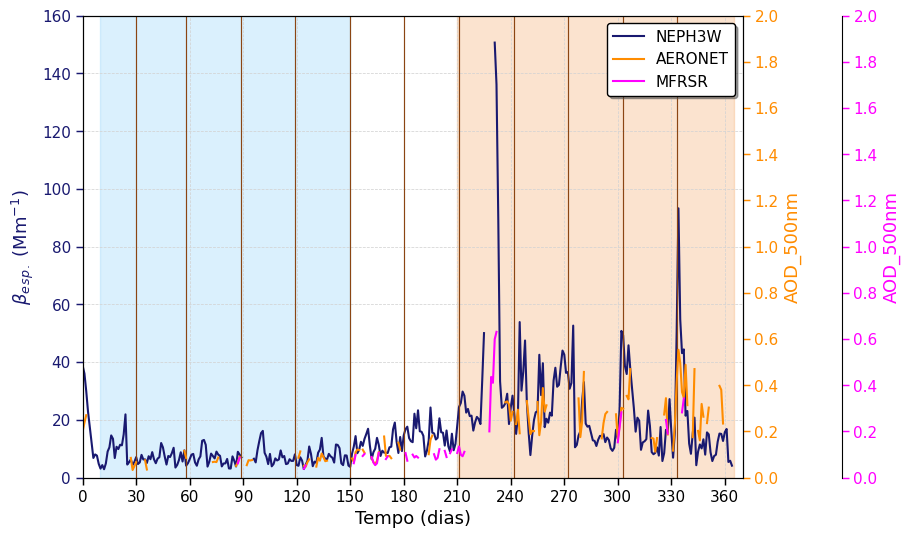

In [9]:
########################################## Configs:
cores = ['midnightblue', 'darkorange', 'magenta', 'saddlebrown']
# cores = ['midnightblue', 'magenta', 'magenta', 'saddlebrown']
limitesx = [0, 370]
limitesy = [0.0, 160.0]
limitesyaod = [0.0, 2.0]
tf = 13

########################################## Elimina e acerta posições dos axes:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
fig, host = plt.subplots(figsize=(8,6), facecolor='white')
fig.subplots_adjust(right=0.95)
par1 = host.twinx()
par2 = host.twinx()
par2.spines["right"].set_position(("axes", 1.15))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)

########################################## Setting dos limites, das legendas e plotting de cada variável:
p1, = host.plot(np.arange(len(colunas14)), stats14[0].T['mean'], color=cores[0], label="NEPH3W")
p2, = par1.plot(np.arange(len(colunas14)), stats14[1].T['mean'], color=cores[1], label="AERONET")
p3, = par2.plot(np.arange(len(colunas14)), stats14[2].T['mean'], color=cores[2], label="MFRSR")
host.set_xlim(limitesx)
host.set_ylim(limitesy)
par1.set_ylim(limitesyaod)
par2.set_ylim(limitesyaod)
# host.set_title(u"2014 Daily Means at T3", fontsize=tf)
host.set_xlabel('Tempo (dias)', fontsize=tf)
host.set_ylabel(labels[0]+' (Mm$^{-1}$)', fontsize=tf)
par1.set_ylabel(labels[1]+'_500nm', fontsize=tf)
par2.set_ylabel(labels[2]+'_500nm', fontsize=tf)
host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())
tkw = dict(size=5, width=1.05)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)
plt.setp(host.get_xticklabels(), rotation=0, fontsize=tf-2)
plt.setp(host.get_yticklabels(), rotation=0, fontsize=tf-2)
plt.setp(par1.get_yticklabels(), rotation=0, fontsize=tf-2)
plt.setp(par2.get_yticklabels(), rotation=0, fontsize=tf-2)

host.xaxis.set_major_locator(ticker.MultipleLocator(30))
host.yaxis.set_major_locator(ticker.MultipleLocator(20))
par1.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
par2.yaxis.set_major_locator(ticker.MultipleLocator(0.2))

lines = [p1, p2, p3]
host.legend(lines, [l.get_label() for l in lines], fontsize=tf-2, loc='upper right', ncol=1, fancybox=True,
            shadow=True, facecolor='white', edgecolor='black')
host.grid(visible=True, which='both', axis='both', color='lightgrey', linestyle='--', linewidth=0.55)

### Desenhando linhas verticais delimitando os meses do ano:
for mes, n in zip([0,1,2,3,4,5,6,7,8,9,10],[30,58,89,119,150,180,211,242,272,303,333]):
    host.vlines(x=n, ymin=limitesy[0], ymax=limitesy[1], colors=cores[3], linewidth=0.85)
    
host.axvspan(xmin=10, xmax=150, color='lightskyblue', alpha=0.3)
host.axvspan(xmin=210, xmax=365, color='sandybrown', alpha=0.3)

# plt.show()
# plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/Series_CenariosAOD_2014.png', 
#             dpi=400, bbox_inches='tight', facecolor='white')

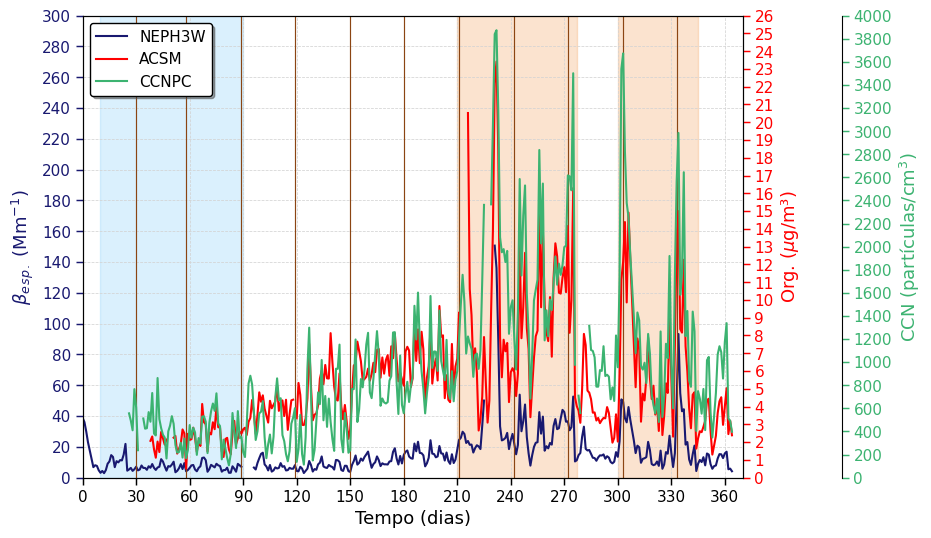

In [10]:
########################################## Configs:
cores = ['midnightblue', 'r', 'mediumseagreen', 'saddlebrown']
limitesx = [0, 370]
limitesy = [0.0, 300.0]
limitesyorg = [0.0, 26]
limitesyccn = [0.0, 4000.0]
tf = 13

########################################## Elimina e acerta posições dos axes:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
fig, host = plt.subplots(figsize=(8,6), facecolor='white')
fig.subplots_adjust(right=0.95)
par1 = host.twinx()
par2 = host.twinx()
par2.spines["right"].set_position(("axes", 1.15))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)

########################################## Setting dos limites, das legendas e plotting de cada variável:
p1, = host.plot(np.arange(len(colunas14)), stats14[0].T['mean'], color=cores[0], label="NEPH3W")
p2, = par1.plot(np.arange(len(colunas14)), stats14[3].T['mean'], color=cores[1], label="ACSM")
p3, = par2.plot(np.arange(len(colunas14)), stats14[4].T['mean'], color=cores[2], label="CCNPC")
host.set_xlim(limitesx)
host.set_ylim(limitesy)
par1.set_ylim(limitesyorg)
par2.set_ylim(limitesyccn)
# host.set_title(u"Médias diárias para o T3 durante 2014", fontsize=tf)
host.set_xlabel('Tempo (dias)', fontsize=tf)
host.set_ylabel(labels[0]+' (Mm$^{-1}$)', fontsize=tf)
par1.set_ylabel(labels[3]+' ($\mu$g/m³)', fontsize=tf)
par2.set_ylabel(labels[4]+' (partículas/cm$^{3}$)', fontsize=tf)
host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())
tkw = dict(size=5, width=1.05)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)
plt.setp(host.get_xticklabels(), rotation=0, fontsize=tf-2)
plt.setp(host.get_yticklabels(), rotation=0, fontsize=tf-2)
plt.setp(par1.get_yticklabels(), rotation=0, fontsize=tf-2)
plt.setp(par2.get_yticklabels(), rotation=0, fontsize=tf-2)

host.xaxis.set_major_locator(ticker.MultipleLocator(30))
host.yaxis.set_major_locator(ticker.MultipleLocator(20))
par1.yaxis.set_major_locator(ticker.MultipleLocator(1))
par2.yaxis.set_major_locator(ticker.MultipleLocator(200))

lines = [p1, p2, p3]
host.legend(lines, [l.get_label() for l in lines], fontsize=tf-2, loc='upper left', ncol=1, fancybox=True,
            shadow=True, facecolor='white', edgecolor='black')
host.grid(visible=True, which='both', axis='both', color='lightgrey', linestyle='--', linewidth=0.55)

### Desenhando linhas verticais delimitando os meses do ano:
for mes, n in zip([0,1,2,3,4,5,6,7,8,9,10],[30,58,89,119,150,180,211,242,272,303,333]):
    host.vlines(x=n, ymin=limitesy[0], ymax=limitesy[1], colors=cores[3], linewidth=0.85)
    
host.axvspan(xmin=10, xmax=90, color='lightskyblue', alpha=0.3)
# host.axvspan(xmin=210, xmax=345, color='sandybrown', alpha=0.3)
host.axvspan(xmin=210, xmax=277, color='sandybrown', alpha=0.3)
host.axvspan(xmin=300, xmax=345, color='sandybrown', alpha=0.3)

# plt.show()
# plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/Series_Cenarios_2014.png', 
#             dpi=400, bbox_inches='tight', facecolor='white')
# plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/Series_CenariosOrgCCN_2014.png', 
#             dpi=400, bbox_inches='tight', facecolor='white')

In [12]:
#################################################################################

In [14]:
print(len(stats14[0].columns))
print(len(stats14[1].columns))
print(len(stats14[2].columns))
print(len(stats14[3].columns))
print(len(stats14[4].columns))

365
365
365
365
365


In [15]:
from termcolor import colored
diaslimpa, diaspoluida, diastransicao1, diastransicao2, diastransicao3, diastransicao4  = [], [], [], [], [], []

for i, col in enumerate(stats14[0].columns):
    if (i<10):
        print('{0} {1}'.format(i, col))
        diastransicao1.append(col)
    elif (i>=10) and (i<=90):
        print(colored('{0} {1}'.format(i, col), 'blue'))
        diaslimpa.append(col)
    elif (i>=91) and (i<210):
        print('{0} {1}'.format(i, col))
        diastransicao2.append(col)
    elif (i>=210) and (i<=277):
        print(colored('{0} {1}'.format(i, col), 'red'))
        diaspoluida.append(col)
    elif (i>=288) and (i<300):
        print('{0} {1}'.format(i, col))
        diastransicao3.append(col)
    elif (i>=300) and (i<=345):
        print(colored('{0} {1}'.format(i, col), 'red'))
        diaspoluida.append(col)
    elif (i>=346) and (i<=364):
        print('{0} {1}'.format(i, col))
        diastransicao4.append(col)

0 01/01/2014
1 02/01/2014
2 03/01/2014
3 04/01/2014
4 05/01/2014
5 06/01/2014
6 07/01/2014
7 08/01/2014
8 09/01/2014
9 10/01/2014
10 11/01/2014
11 12/01/2014
12 13/01/2014
13 14/01/2014
14 15/01/2014
15 16/01/2014
16 17/01/2014
17 18/01/2014
18 19/01/2014
19 20/01/2014
20 21/01/2014
21 22/01/2014
22 23/01/2014
23 24/01/2014
24 25/01/2014
25 26/01/2014
26 27/01/2014
27 28/01/2014
28 29/01/2014
29 30/01/2014
30 31/01/2014
31 01/02/2014
32 02/02/2014
33 03/02/2014
34 04/02/2014
35 05/02/2014
36 06/02/2014
37 07/02/2014
38 08/02/2014
39 09/02/2014
40 10/02/2014
41 11/02/2014
42 12/02/2014
43 13/02/2014
44 14/02/2014
45 15/02/2014
46 16/02/2014
47 17/02/2014
48 18/02/2014
49 19/02/2014
50 20/02/2014
51 21/02/2014
52 22/02/2014
53 23/02/2014
54 24/02/2014
55 25/02/2014
56 26/02/2014
57 27/02/2014
58 28/02/2014
59 01/03/2014
60 02/03/2014
61 03/03/2014
62 04/03/2014
63 05/03/2014
64 06/03/2014
65 07/03/2014
66 08/03/2014
67 09/03/2014
68 10/03/2014
69 11/03/2014
70 12/03/2014
71 13/03/2014
72

In [16]:
nans1, nans2, nans3, nans4, nans5, nans6 = [], [], [], [], [], []
for i in range(len(diastransicao1)):
    nans1.append(np.nan)
for i in range(len(diaslimpa)):
    nans2.append(np.nan)
for i in range(len(diastransicao2)):
    nans3.append(np.nan)
for i in range(len(diaspoluida)):
    nans4.append(np.nan)
for i in range(len(diastransicao3)):
    nans5.append(np.nan)
for i in range(len(diastransicao4)):
    nans6.append(np.nan)

In [25]:
d1, d2, dt1, dt2, dt3, dt4 = {}, {}, {}, {}, {}, {}
for col in diaslimpa:
    d1.update({col:[np.nan, np.nan]})
dfdlimpa = pd.DataFrame(d1)
for col in diaspoluida:
    d2.update({col:[np.nan, np.nan]})
dfdpoluida = pd.DataFrame(d2)
for col in diastransicao1:
    dt1.update({col:[np.nan, np.nan]})
dfdtransicao1 = pd.DataFrame(dt1)
for col in diastransicao2:
    dt2.update({col:[np.nan, np.nan]})
dfdtransicao2 = pd.DataFrame(dt2)
for col in diastransicao3:
    dt3.update({col:[np.nan, np.nan]})
dfdtransicao3 = pd.DataFrame(dt3)
for col in diastransicao4:
    dt4.update({col:[np.nan, np.nan]})
dfdtransicao4 = pd.DataFrame(dt4)

directory = '/mnt/HD_500GB_WD/historia2/Analises_Aerossois/'
dfdlimpa.to_pickle(directory+'diaslimpa14.pkl')
dfdpoluida.to_pickle(directory+'diaspoluida14.pkl')
dfdtransicao1.to_pickle(directory+'diastransicao14_1.pkl')
dfdtransicao2.to_pickle(directory+'diastransicao14_2.pkl')
dfdtransicao3.to_pickle(directory+'diastransicao14_3.pkl')
dfdtransicao4.to_pickle(directory+'diastransicao14_4.pkl')

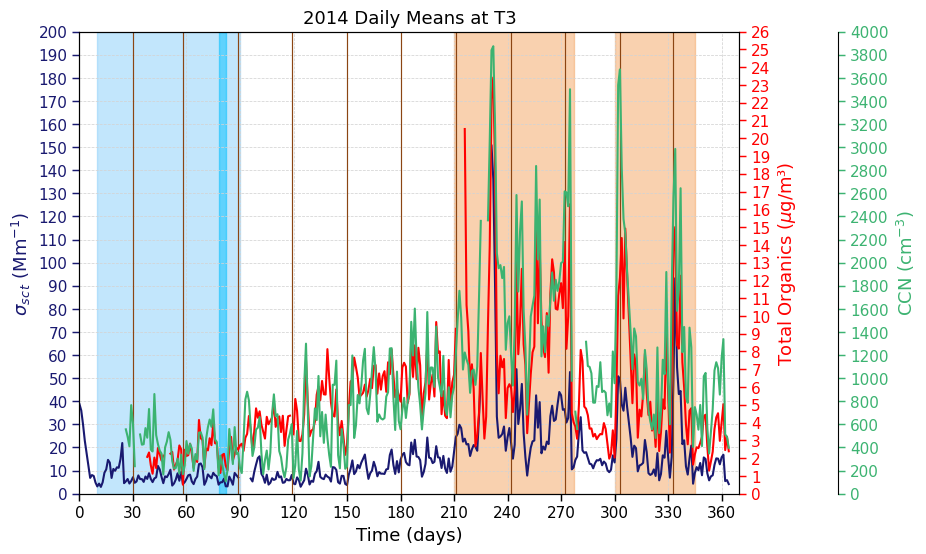

In [27]:
########################################## Configs:
cores = ['midnightblue', 'r', 'mediumseagreen', 'saddlebrown']
limitesx = [0, 370]
limitesy = [0.0, 200.0]
limitesyorg = [0.0, 26]
limitesyccn = [0.0, 4000.0]
tf = 13

########################################## Elimina e acerta posições dos axes:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
fig, host = plt.subplots(figsize=(8,6), facecolor='white')
fig.subplots_adjust(right=0.95)
par1 = host.twinx()
par2 = host.twinx()
par2.spines["right"].set_position(("axes", 1.15))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)

########################################## Setting dos limites, das legendas e plotting de cada variável:
p1, = host.plot(np.arange(len(colunas14)), stats14[0].T['mean'], color=cores[0], label="NEPH3W Green 1$\mu$m")
p2, = par1.plot(np.arange(len(colunas14)), stats14[3].T['mean'], color=cores[1], label="ACSM")
p3, = par2.plot(np.arange(len(colunas14)), stats14[4].T['mean'], color=cores[2], label="CCNPC")
host.set_xlim(limitesx)
host.set_ylim(limitesy)
par1.set_ylim(limitesyorg)
par2.set_ylim(limitesyccn)
host.set_title(u"2014 Daily Means at T3", fontsize=tf)
host.set_xlabel('Time (days)', fontsize=tf)
host.set_ylabel(labels[0]+' (Mm$^{-1}$)', fontsize=tf)
par1.set_ylabel(labels[3]+' ($\mu$g/m³)', fontsize=tf)
par2.set_ylabel(labels[4]+' (cm$^{-3}$)', fontsize=tf)
host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())
tkw = dict(size=5, width=1.05)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)
plt.setp(host.get_xticklabels(), rotation=0, fontsize=tf-2)
plt.setp(host.get_yticklabels(), rotation=0, fontsize=tf-2)
plt.setp(par1.get_yticklabels(), rotation=0, fontsize=tf-2)
plt.setp(par2.get_yticklabels(), rotation=0, fontsize=tf-2)

host.xaxis.set_major_locator(ticker.MultipleLocator(30))
host.yaxis.set_major_locator(ticker.MultipleLocator(10))
par1.yaxis.set_major_locator(ticker.MultipleLocator(1))
par2.yaxis.set_major_locator(ticker.MultipleLocator(200))

lines = [p1, p2, p3]
# host.legend(lines, [l.get_label() for l in lines], fontsize=tf-2, loc='upper left', ncol=1, fancybox=True,
#             shadow=True, facecolor='white', edgecolor='black')
host.grid(visible=True, which='both', axis='both', color='lightgrey', linestyle='--', linewidth=0.55)

### Desenhando linhas verticais delimitando os meses do ano:
for mes, n in zip([0,1,2,3,4,5,6,7,8,9,10],[30,58,89,119,150,180,211,242,272,303,333]):
    host.vlines(x=n, ymin=limitesy[0], ymax=limitesy[1], colors=cores[3], linewidth=0.85)
    
host.axvspan(xmin=10, xmax=90, color='lightskyblue', alpha=0.5)
# host.axvspan(xmin=210, xmax=345, color='sandybrown', alpha=0.5)
host.axvspan(xmin=210, xmax=277, color='sandybrown', alpha=0.5)
host.axvspan(xmin=300, xmax=345, color='sandybrown', alpha=0.5)

host.axvspan(xmin=78, xmax=82, color='deepskyblue', alpha=0.5)


# host.axvspan(xmin=231, xmax=232, color='yellow', alpha=0.5)

plt.show()